<a href="https://colab.research.google.com/github/mchchoi/factorization/blob/main/factored_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:258: SyntaxWarning: invalid escape sequence '\h'
<>:290: SyntaxWarning: invalid escape sequence '\h'
<>:326: SyntaxWarning: invalid escape sequence '\h'
<>:258: SyntaxWarning: invalid escape sequence '\h'
<>:290: SyntaxWarning: invalid escape sequence '\h'
<>:326: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-4090176148.py:258: SyntaxWarning: invalid escape sequence '\h'
  Build the product-projected kernel \hat P_q = \otimes_i P_q^{(i)} in param form.
/tmp/ipython-input-4090176148.py:290: SyntaxWarning: invalid escape sequence '\h'
  """One-step prediction of marginals under \hat P_q (product kernel): q_p' = q_p P_q^{(i)} for each i."""
/tmp/ipython-input-4090176148.py:326: SyntaxWarning: invalid escape sequence '\h'
  Compute I^q(P) = E_{X~q} [ KL(P(X,·) || \hat P_q(X,·)) ] for the random-scan heat-bath Ising dynamics,


Experiment 1: time-avg marginal error = 0.003128939927995217
Experiment 1: time-avg I^q(P)         = 0.022646309314342528
Experiment 1: corr(Err_marg(t), I^q_t(P)) = 0.5183334851562389


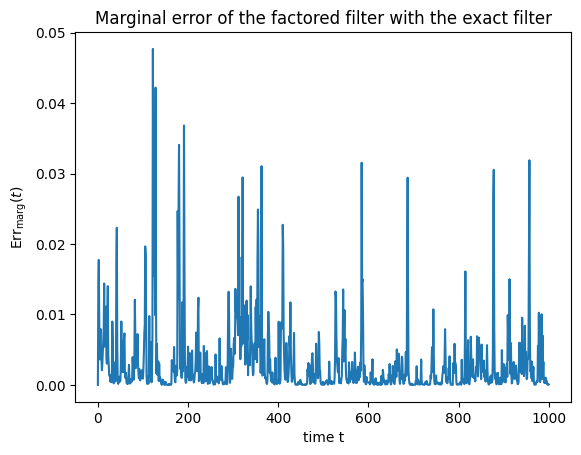

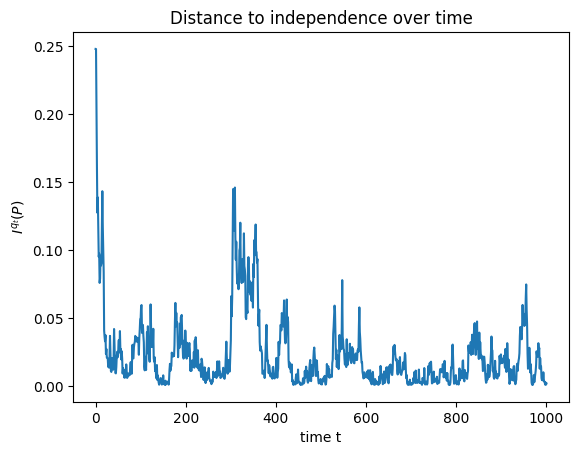

In [ ]:
"""

Latent chain: random-scan single-site heat-bath (Glauber) dynamics on an LxL grid.
Observations: independent flip noise at each node: P(Y_i = X_i) = 1-eps, P(Y_i = -X_i) = eps.

Experiment 1:
  - Fix (beta, eps), simulate one trajectory, run:
      (i) exact filter on full state space (size 2^d, feasible for d=16),
      (ii) KL-projected product filter (factored filter),
    and track marginal errors + distance-to-independence I^q(P) over time.

Notes:
  - This code is written for small d (e.g. L=4 => d=16) so exact filtering is feasible.
  - For larger d, you can still run the factored filter; just skip the exact baseline.
"""

from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional


def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))


def make_grid_neighbors(L: int, periodic: bool = False) -> List[List[int]]:
    """4-neighborhood on an LxL grid, row-major indexing."""
    d = L * L
    nbrs: List[List[int]] = [[] for _ in range(d)]

    def idx(r: int, c: int) -> int:
        return r * L + c

    for r in range(L):
        for c in range(L):
            i = idx(r, c)
            candidates = [(r - 1, c), (r + 1, c), (r, c - 1), (r, c + 1)]
            for rr, cc in candidates:
                if periodic:
                    rr %= L
                    cc %= L
                    nbrs[i].append(idx(rr, cc))
                else:
                    if 0 <= rr < L and 0 <= cc < L:
                        nbrs[i].append(idx(rr, cc))
    return nbrs


def enumerate_states_bits(d: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Enumerate all 2^d states as integers 0..N-1.
    bits: (N,d) in {0,1}, where bit=1 corresponds to spin +1, bit=0 to spin -1.
    spins: (N,d) in {-1,+1}.
    """
    N = 1 << d
    idx = np.arange(N, dtype=np.uint32)
    bit_positions = np.arange(d, dtype=np.uint32)
    bits = ((idx[:, None] >> bit_positions[None, :]) & 1).astype(np.uint8)
    spins = (2 * bits - 1).astype(np.int8)
    return idx, bits, spins


def precompute_neighbor_sums(spins: np.ndarray, nbrs: List[List[int]]) -> np.ndarray:
    """
    neighbor_sums[i, x] = sum_{j in N(i)} spins[x, j]
    Shape: (d, N)
    """
    N, d = spins.shape
    out = np.zeros((d, N), dtype=np.int8)
    for i in range(d):
        if len(nbrs[i]) == 0:
            continue
        out[i] = spins[:, nbrs[i]].sum(axis=1).astype(np.int8)
    return out


def popcount_uint32(x: np.ndarray) -> np.ndarray:
    """Vectorized popcount for uint32 using a byte lookup table."""
    x = x.astype(np.uint32, copy=False)
    table = popcount_uint32._table  # type: ignore[attr-defined]
    b = x.view(np.uint8).reshape(-1, 4)
    return (table[b[:, 0]] + table[b[:, 1]] + table[b[:, 2]] + table[b[:, 3]]).astype(np.int16)


# Initialize popcount table
popcount_uint32._table = np.array([bin(i).count("1") for i in range(256)], dtype=np.uint8)  # type: ignore[attr-defined]


@dataclass
class IsingPrecomp:
    L: int
    d: int
    N: int
    nbrs: List[List[int]]
    indices: np.ndarray          # (N,)
    bits: np.ndarray             # (N,d)
    spins: np.ndarray            # (N,d)
    neighbor_sums: np.ndarray    # (d,N)
    y_plus: np.ndarray           # (d,N)
    y_minus: np.ndarray          # (d,N)

    @staticmethod
    def build(L: int, periodic: bool = False) -> "IsingPrecomp":
        d = L * L
        N = 1 << d
        nbrs = make_grid_neighbors(L, periodic=periodic)
        indices, bits, spins = enumerate_states_bits(d)
        neighbor_sums = precompute_neighbor_sums(spins, nbrs)

        # Precompute destination indices for setting bit i to 1 or 0.
        y_plus = np.zeros((d, N), dtype=np.uint32)
        y_minus = np.zeros((d, N), dtype=np.uint32)
        for i in range(d):
            mask = np.uint32(1 << i)
            y_plus[i] = indices | mask
            y_minus[i] = indices & (~mask)
        return IsingPrecomp(L, d, N, nbrs, indices, bits, spins, neighbor_sums, y_plus, y_minus)


def predict_exact(pi: np.ndarray, beta: float, pre: IsingPrecomp, pplus_all: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Exact prediction: pi_next = pi P, where P is random-scan heat-bath Glauber kernel.
    Works without explicitly building P. Complexity O(d*N).
    If pplus_all is provided, it must be shape (d,N) with pplus_all[i,x] = P(new spin at i = +1 | neighbors in state x).
    """
    d, N = pre.d, pre.N
    pi = pi.astype(np.float64, copy=False)
    out = np.zeros_like(pi)
    choose = 1.0 / d

    if pplus_all is None:
        # Compute on the fly
        for i in range(d):
            S = pre.neighbor_sums[i].astype(np.float64)
            pplus = sigmoid(2.0 * beta * S)
            w_plus = pi * (choose * pplus)
            w_minus = pi * (choose * (1.0 - pplus))
            out += np.bincount(pre.y_plus[i], weights=w_plus, minlength=N)
            out += np.bincount(pre.y_minus[i], weights=w_minus, minlength=N)
    else:
        for i in range(d):
            pplus = pplus_all[i]
            w_plus = pi * (choose * pplus)
            w_minus = pi * (choose * (1.0 - pplus))
            out += np.bincount(pre.y_plus[i], weights=w_plus, minlength=N)
            out += np.bincount(pre.y_minus[i], weights=w_minus, minlength=N)

    s = out.sum()
    if not np.isfinite(s) or s <= 0:
        raise RuntimeError("Prediction produced invalid distribution.")
    return out / s


def update_exact(pi_pred: np.ndarray, ymask: int, eps: float, pre: IsingPrecomp) -> np.ndarray:
    """
    Exact Bayes update with node-wise flip noise:
      g(y|x) = (1-eps)^{d-k} eps^k where k = Hamming distance between x and y (as bitmasks for +1 spins).
    """
    d, N = pre.d, pre.N
    idx = pre.indices
    ymask_u = np.uint32(ymask)
    xor = np.bitwise_xor(idx, ymask_u)
    k = popcount_uint32(xor).astype(np.int16)

    # log-likelihood up to constant
    log1 = np.log(1.0 - eps)
    loge = np.log(eps)
    logw = (d - k) * log1 + k * loge
    # stabilize
    logw = logw - np.max(logw)

    w = np.exp(logw)
    post = pi_pred * w
    s = post.sum()
    if not np.isfinite(s) or s <= 0:
        raise RuntimeError("Update produced invalid distribution.")
    return post / s


def marginals_from_pi(pi: np.ndarray, pre: IsingPrecomp) -> np.ndarray:
    """Return p_i = P(X_i = +1) under full distribution pi."""
    # bits are 0/1 for +1, so E[bit] = P(+1).
    return pi @ pre.bits  # (d,)


def simulate_glauber_trajectory(
    beta: float, eps: float, T: int, pre: IsingPrecomp, seed: int = 0, x0: Optional[np.ndarray] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate latent X_t (spins) and observations Y_t for t=0..T.
    Returns:
      X: (T+1, d) in {-1,+1}
      Y: (T+1, d) in {-1,+1}
    """
    rng = np.random.default_rng(seed)
    d = pre.d

    if x0 is None:
        X = rng.choice(np.array([-1, 1], dtype=np.int8), size=(T + 1, d))
        X[0] = rng.choice(np.array([-1, 1], dtype=np.int8), size=d)
    else:
        X = np.empty((T + 1, d), dtype=np.int8)
        X[0] = x0.astype(np.int8)

    # simulate latent chain
    for t in range(T):
        x = X[t].copy()
        i = rng.integers(0, d)
        S = int(x[pre.nbrs[i]].sum()) if len(pre.nbrs[i]) > 0 else 0
        pplus = float(sigmoid(np.array(2.0 * beta * S)))
        x[i] = 1 if rng.random() < pplus else -1
        X[t + 1] = x

    # observations via independent flip noise
    flips = rng.random(size=(T + 1, d)) < eps
    Y = X.copy()
    Y[flips] *= -1
    return X, Y


def spins_to_bitmask(spins_vec: np.ndarray) -> int:
    """Convert spins in {-1,+1} to a bitmask (bit=1 means +1)."""
    bits = (spins_vec > 0).astype(np.uint32)
    mask = np.uint32(0)
    for i, b in enumerate(bits):
        if b:
            mask |= np.uint32(1 << i)
    return int(mask)


def expected_pplus_under_product(nei_probs: np.ndarray, beta: float) -> float:
    """
    If neighbor spins are independent with P(+1)=p_j, return E[ sigmoid(2 beta * sum neighbors) ].
    Enumerates 2^deg neighbor configurations (deg <= 4 on grid).
    """
    k = len(nei_probs)
    if k == 0:
        return float(sigmoid(np.array(0.0)))  # sigmoid(0)=1/2

    total = 0.0
    for m in range(1 << k):
        prob = 1.0
        S = 0
        for j in range(k):
            if (m >> j) & 1:
                prob *= float(nei_probs[j])
                S += 1
            else:
                prob *= float(1.0 - nei_probs[j])
                S -= 1
        total += prob * float(sigmoid(np.array(2.0 * beta * S)))
    return total


def projected_product_kernel_params(q_p: np.ndarray, beta: float, pre: IsingPrecomp) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Build the product-projected kernel \hat P_q = \otimes_i P_q^{(i)} in param form.
    Return arrays (length d):
      stay_plus[i]  = P_q^{(i)}(+ -> +)
      flip_plus[i]  = P_q^{(i)}(+ -> -)
      flip_minus[i] = P_q^{(i)}(- -> +)
      stay_minus[i] = P_q^{(i)}(- -> -)
    under random-scan heat-bath dynamics.
    """
    d = pre.d
    choose = 1.0 / d
    not_choose = 1.0 - choose

    stay_plus = np.empty(d, dtype=np.float64)
    flip_plus = np.empty(d, dtype=np.float64)
    flip_minus = np.empty(d, dtype=np.float64)
    stay_minus = np.empty(d, dtype=np.float64)

    for i in range(d):
        nei = pre.nbrs[i]
        nei_probs = q_p[np.array(nei, dtype=int)] if len(nei) > 0 else np.array([], dtype=np.float64)
        m_i = expected_pplus_under_product(nei_probs, beta)  # E[pplus | neighbors ~ product(q)]
        # When i not chosen: spin stays.
        # When i chosen: new spin is + with prob m_i, - with prob 1-m_i.
        stay_plus[i] = not_choose + choose * m_i
        flip_plus[i] = choose * (1.0 - m_i)
        flip_minus[i] = choose * m_i
        stay_minus[i] = not_choose + choose * (1.0 - m_i)

    return stay_plus, flip_plus, flip_minus, stay_minus


def predict_projected_product(q_p: np.ndarray, stay_plus: np.ndarray, flip_plus: np.ndarray, flip_minus: np.ndarray, stay_minus: np.ndarray) -> np.ndarray:
    """One-step prediction of marginals under \hat P_q (product kernel): q_p' = q_p P_q^{(i)} for each i."""
    # q_p[i] = P(X_i=+1). Update Bernoulli with 2x2 transition:
    # P(+ -> +) = stay_plus, P(- -> +) = flip_minus
    return q_p * stay_plus + (1.0 - q_p) * flip_minus


def update_projected_product(q_p_pred: np.ndarray, y_vec: np.ndarray, eps: float) -> np.ndarray:
    """
    Node-wise Bayes update under independent flip noise:
      P(Y_i = X_i) = 1-eps, P(Y_i = -X_i) = eps.
    """
    # Likelihood factors:
    # If y_i=+1: g(+|+)=1-eps, g(+|-)=eps
    # If y_i=-1: g(-|+)=eps, g(-|-)=1-eps
    y_is_plus = (y_vec > 0)
    g_plus = np.where(y_is_plus, 1.0 - eps, eps)     # g(y_i | X_i=+)
    g_minus = np.where(y_is_plus, eps, 1.0 - eps)    # g(y_i | X_i=-)

    num = q_p_pred * g_plus
    den = num + (1.0 - q_p_pred) * g_minus
    # avoid 0/0
    den = np.maximum(den, 1e-300)
    return num / den


def compute_Iq_distance_to_independence(
    q_p: np.ndarray,
    beta: float,
    pre: IsingPrecomp,
    pplus_all: np.ndarray,
    stay_plus: np.ndarray,
    flip_plus: np.ndarray,
    flip_minus: np.ndarray,
    stay_minus: np.ndarray,
) -> float:
    """
    Compute I^q(P) = E_{X~q} [ KL(P(X,·) || \hat P_q(X,·)) ] for the random-scan heat-bath Ising dynamics,
    where q is the product measure defined by marginals q_p (P(X_i=+1)=q_p[i]).

    This is exact on the full state space (feasible for d=16).
    """
    d, N = pre.d, pre.N
    bits = pre.bits.astype(np.float64)

    # Build full product distribution q(x) on states x=0..N-1
    logp = np.log(np.clip(q_p, 1e-300, 1.0))
    logm = np.log(np.clip(1.0 - q_p, 1e-300, 1.0))
    logq = bits @ logp + (1.0 - bits) @ logm
    logq = logq - np.max(logq)
    q_full = np.exp(logq)
    q_full /= q_full.sum()

    # Precompute log stay/flip probs for \hat P_q depending on x_i
    log_stay_plus = np.log(np.clip(stay_plus, 1e-300, 1.0))
    log_stay_minus = np.log(np.clip(stay_minus, 1e-300, 1.0))
    log_flip_plus = np.log(np.clip(flip_plus, 1e-300, 1.0))       # + -> -
    log_flip_minus = np.log(np.clip(flip_minus, 1e-300, 1.0))     # - -> +

    # log \hat P_q(x,x) = sum_i log stay_i(x_i)
    # stay_i(x_i) = stay_plus[i] if x_i=+ else stay_minus[i]
    log_hat_self = bits @ log_stay_plus + (1.0 - bits) @ log_stay_minus

    # Compute flip probs under true P for each i, aggregated per flip state (unique per i).
    choose = 1.0 / d
    Iq = 0.0

    # For efficiency, compute P_self(x) by subtracting sum flip_i
    P_self = np.ones(N, dtype=np.float64)

    # We'll accumulate KL contributions in vectors then dot with q_full at the end.
    kl = np.zeros(N, dtype=np.float64)

    # Add flip terms
    for i in range(d):
        bi = bits[:, i]  # 0/1
        pplus = pplus_all[i]  # length N

        # True flip prob at site i:
        # if x_i=+ => flip to - with prob (1/d)*(1-pplus)
        # if x_i=- => flip to + with prob (1/d)*pplus
        P_flip = choose * (bi * (1.0 - pplus) + (1.0 - bi) * pplus)
        P_self -= P_flip

        # log \hat P_q(x, flip_i) = log_hat_self - log stay_i(x_i) + log flip_i(x_i)
        log_stay_i = bi * log_stay_plus[i] + (1.0 - bi) * log_stay_minus[i]
        log_flip_i = bi * log_flip_plus[i] + (1.0 - bi) * log_flip_minus[i]
        log_hat_flip = log_hat_self - log_stay_i + log_flip_i

        P_flip_c = np.clip(P_flip, 1e-300, 1.0)
        kl += P_flip_c * (np.log(P_flip_c) - log_hat_flip)

    # Add self term
    P_self_c = np.clip(P_self, 1e-300, 1.0)
    kl += P_self_c * (np.log(P_self_c) - log_hat_self)

    Iq = float(np.dot(q_full, kl))
    return Iq


# -------------------------
# Experiment 1
# -------------------------

def run_experiment_1(
    L: int = 4,
    beta: float = 0.6,
    eps: float = 0.1,
    T: int = 40,
    seed: int = 0,
    periodic: bool = False,
    compute_Iq: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Returns dict with arrays over time (t=0..T):
      err_marg[t] : mean_i | q_i(+1) - pi_i(+1) |
      err_mag[t]  : | m_q - m_pi | where m = sum_i E[X_i]
      Iq[t]       : distance-to-independence at posterior q_t (if compute_Iq)
    """
    pre = IsingPrecomp.build(L, periodic=periodic)
    d, N = pre.d, pre.N

    # Precompute pplus_all for this beta on all states (for exact prediction + Iq)
    pplus_all = sigmoid(2.0 * beta * pre.neighbor_sums.astype(np.float64))  # (d,N)

    # Simulate trajectory
    X, Y = simulate_glauber_trajectory(beta=beta, eps=eps, T=T, pre=pre, seed=seed)

    # Initialize filters
    pi = np.full(N, 1.0 / N, dtype=np.float64)  # exact belief on full state space
    q_p = np.full(d, 0.5, dtype=np.float64)     # factored belief: p_i = P(+1)

    err_marg = np.zeros(T + 1, dtype=np.float64)
    err_mag = np.zeros(T + 1, dtype=np.float64)
    Iq_arr = np.full(T + 1, np.nan, dtype=np.float64)

    # Filtering loop
    for t in range(T + 1):
        # Update with observation y_t
        ymask = spins_to_bitmask(Y[t])
        pi = update_exact(pi, ymask=ymask, eps=eps, pre=pre)

        # Factored update: since likelihood factorizes, update coordinatewise
        q_p = update_projected_product(q_p_pred=q_p, y_vec=Y[t], eps=eps)

        # Compare marginals after update
        p_exact = marginals_from_pi(pi, pre)                  # P(X_i=+1)
        err_marg[t] = float(np.mean(np.abs(q_p - p_exact)))

        # Magnetization: E[X_i] = 2P(+1)-1
        m_q = float(np.sum(2.0 * q_p - 1.0))
        m_pi = float(np.sum(2.0 * p_exact - 1.0))
        err_mag[t] = abs(m_q - m_pi)

        # Build projected kernel around current q_p for the next prediction
        stay_plus, flip_plus, flip_minus, stay_minus = projected_product_kernel_params(q_p, beta, pre)

        # Distance to independence I^{q_t}(P)
        if compute_Iq:
            Iq_arr[t] = compute_Iq_distance_to_independence(
                q_p=q_p,
                beta=beta,
                pre=pre,
                pplus_all=pplus_all,
                stay_plus=stay_plus,
                flip_plus=flip_plus,
                flip_minus=flip_minus,
                stay_minus=stay_minus,
            )

        # Predict to the next time (skip at last step)
        if t < T:
            pi = predict_exact(pi, beta=beta, pre=pre, pplus_all=pplus_all)
            q_p = predict_projected_product(q_p, stay_plus, flip_plus, flip_minus, stay_minus)

    return {"err_marg": err_marg, "err_mag": err_mag, "Iq": Iq_arr}


# -------------------------
# Experiment 2
# -------------------------

def run_experiment_2(
    L: int = 4,
    betas: np.ndarray = np.array([0.2, 0.4, 0.6, 0.8], dtype=np.float64),
    eps_list: np.ndarray = np.array([0.05, 0.10, 0.20], dtype=np.float64),
    T: int = 30,
    n_trials: int = 3,
    periodic: bool = False,
    seed0: int = 0,
    compute_Iq: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Sweep (beta, eps). For each pair, run n_trials independent trajectories and average:
      avg_err[ib, ie] : time-averaged mean marginal error over t=0..T
      avg_Iq[ib, ie]  : time-averaged I^{q_t}(P) over t=0..T (if compute_Iq)

    Returns dict with:
      avg_err: (len(betas), len(eps_list))
      avg_Iq:  (len(betas), len(eps_list)) (nan if compute_Iq=False)
    """
    pre = IsingPrecomp.build(L, periodic=periodic)
    d, N = pre.d, pre.N

    avg_err = np.zeros((len(betas), len(eps_list)), dtype=np.float64)
    avg_Iq = np.full((len(betas), len(eps_list)), np.nan, dtype=np.float64)

    for ib, beta in enumerate(betas):
        # Precompute pplus_all for this beta (used by exact prediction + Iq)
        pplus_all = sigmoid(2.0 * beta * pre.neighbor_sums.astype(np.float64))  # (d,N)

        for ie, eps in enumerate(eps_list):
            errs = []
            Iqs = []

            for k in range(n_trials):
                seed = seed0 + 1000 * ib + 100 * ie + k

                # Simulate a trajectory for this (beta, eps)
                X, Y = simulate_glauber_trajectory(beta=beta, eps=eps, T=T, pre=pre, seed=seed)

                # Initialize filters
                pi = np.full(N, 1.0 / N, dtype=np.float64)
                q_p = np.full(d, 0.5, dtype=np.float64)

                err_t = []
                Iq_t = []

                for t in range(T + 1):
                    # Update
                    ymask = spins_to_bitmask(Y[t])
                    pi = update_exact(pi, ymask=ymask, eps=eps, pre=pre)
                    q_p = update_projected_product(q_p_pred=q_p, y_vec=Y[t], eps=eps)

                    # Error after update
                    p_exact = marginals_from_pi(pi, pre)
                    err_t.append(float(np.mean(np.abs(q_p - p_exact))))

                    # Build projected kernel around q_p
                    stay_plus, flip_plus, flip_minus, stay_minus = projected_product_kernel_params(q_p, beta, pre)

                    if compute_Iq:
                        Iq_val = compute_Iq_distance_to_independence(
                            q_p=q_p,
                            beta=beta,
                            pre=pre,
                            pplus_all=pplus_all,
                            stay_plus=stay_plus,
                            flip_plus=flip_plus,
                            flip_minus=flip_minus,
                            stay_minus=stay_minus,
                        )
                        Iq_t.append(float(Iq_val))

                    # Predict
                    if t < T:
                        pi = predict_exact(pi, beta=beta, pre=pre, pplus_all=pplus_all)
                        q_p = predict_projected_product(q_p, stay_plus, flip_plus, flip_minus, stay_minus)

                errs.append(float(np.mean(err_t)))
                if compute_Iq:
                    Iqs.append(float(np.mean(Iq_t)))

            avg_err[ib, ie] = float(np.mean(errs))
            if compute_Iq:
                avg_Iq[ib, ie] = float(np.mean(Iqs))

    return {"avg_err": avg_err, "avg_Iq": avg_Iq, "betas": betas, "eps_list": eps_list}


# -------------------------
# quick plotting helpers
# -------------------------

def plot_experiment_1(results: Dict[str, np.ndarray]) -> None:
    import matplotlib.pyplot as plt
    t = np.arange(len(results["err_marg"]))
    plt.figure()
    plt.plot(t, results["err_marg"])
    plt.xlabel("time t")
    plt.ylabel(r"$\mathrm{Err}_{\mathrm{marg}}(t)$")
    plt.title("Marginal error of the factored filter with the exact filter")
    plt.show()

    if np.any(np.isfinite(results["Iq"])):
        plt.figure()
        plt.plot(t, results["Iq"])
        plt.xlabel("time t")
        plt.ylabel(r"$I^{q_t}(P)$")
        plt.title("Distance to independence over time")
        plt.show()


def plot_experiment_2(grid: Dict[str, np.ndarray], which: str = "avg_err") -> None:
    import matplotlib.pyplot as plt
    betas = grid["betas"]
    eps_list = grid["eps_list"]
    Z = grid[which]
    plt.figure()
    plt.imshow(Z, aspect="auto", origin="lower")
    plt.xticks(np.arange(len(eps_list)), [f"{e:.2f}" for e in eps_list])
    plt.yticks(np.arange(len(betas)), [f"{b:.2f}" for b in betas])
    plt.xlabel("eps (observation flip prob)")
    plt.ylabel("beta (inverse temperature)")
    plt.title(which)
    plt.colorbar()
    plt.show()


if __name__ == "__main__":
    # ---- Experiment 1 demo ----
    res1 = run_experiment_1(L=4, beta=0.6, eps=0.1, T=1000, seed=0, periodic=False, compute_Iq=True)
    print("Experiment 1: time-avg marginal error =", res1["err_marg"].mean())
    print("Experiment 1: time-avg I^q(P)         =", np.nanmean(res1["Iq"]))

    # Correlation between Err_marg(t) and I^q_t(P) across time (ignoring NaNs)
    mask = np.isfinite(res1["Iq"]) & np.isfinite(res1["err_marg"])
    corr = np.corrcoef(res1["err_marg"][mask], res1["Iq"][mask])[0, 1] if mask.sum() >= 2 else np.nan
    print("Experiment 1: corr(Err_marg(t), I^q_t(P)) =", corr)

    # Uncomment to plot
    plot_experiment_1(res1)

    # ---- Experiment 2 demo ----
    #grid = run_experiment_2(
    #    L=4,
    #    betas=np.array([0.2, 0.4, 0.6, 0.8]),
    #    eps_list=np.array([0.05, 0.10, 0.20]),
    #    T=20,
    #    n_trials=2,
    #    periodic=False,
    #    seed0=0,
    #    compute_Iq=True,
    #)
    #print("Experiment 2 avg_err:\n", grid["avg_err"])
    #print("Experiment 2 avg_Iq:\n", grid["avg_Iq"])

    # Uncomment to plot heatmaps
    #plot_experiment_2(grid, which="avg_err")
    #plot_experiment_2(grid, which="avg_Iq")

[Exact] L= 2, d=   4, sec/step=4.057349e-04
[Exact] L= 3, d=   9, sec/step=8.180037e-04
[Exact] L= 4, d=  16, sec/step=3.221753e-02
[Factored] L= 2, d=   4, sec/step=1.154634e-04
[Factored] L= 3, d=   9, sec/step=4.345943e-04
[Factored] L= 4, d=  16, sec/step=8.817998e-04
[Factored] L= 6, d=  36, sec/step=3.611767e-03
[Factored] L= 8, d=  64, sec/step=2.791790e-03
[Factored] L=10, d= 100, sec/step=3.646455e-03
[Factored] L=12, d= 144, sec/step=5.495948e-03
[Factored] L=16, d= 256, sec/step=9.765833e-03
[Factored] L=20, d= 400, sec/step=1.547998e-02
[Factored] L=24, d= 576, sec/step=2.274883e-02
[Factored] L=30, d= 900, sec/step=5.096180e-02
[Factored] L=40, d=1600, sec/step=6.530226e-02
[Factored] L=50, d=2500, sec/step=1.185011e-01
[Factored] L=100, d=10000, sec/step=4.684148e-01


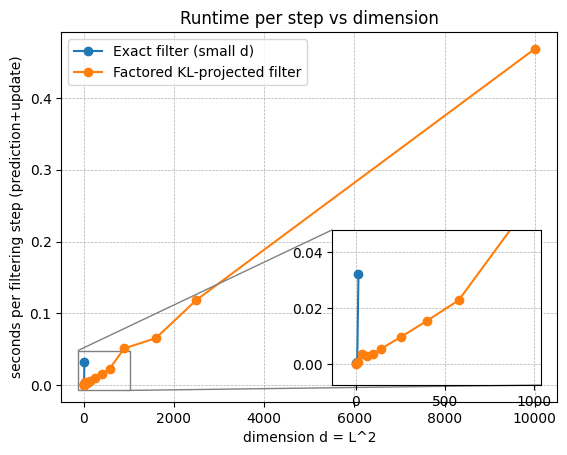

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


# -------------------------
# Utilities
# -------------------------

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def make_grid_neighbors(L: int, periodic: bool = False) -> List[List[int]]:
    """4-neighborhood on an LxL grid, row-major indexing."""
    d = L * L
    nbrs = [[] for _ in range(d)]

    def idx(r, c): return r * L + c

    for r in range(L):
        for c in range(L):
            i = idx(r, c)
            candidates = [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]
            for rr, cc in candidates:
                if periodic:
                    rr %= L
                    cc %= L
                    nbrs[i].append(idx(rr, cc))
                else:
                    if 0 <= rr < L and 0 <= cc < L:
                        nbrs[i].append(idx(rr, cc))
    return nbrs


def simulate_glauber_trajectory(L: int, beta: float, eps: float, T: int, seed: int,
                               periodic: bool = False) -> Tuple[np.ndarray, np.ndarray, List[List[int]]]:
    """
    Simulate latent X_t and observed Y_t under:
      - random-scan single-site heat-bath Glauber Ising dynamics
      - node-wise flip noise observations
    Returns X, Y in {-1,+1}^{T+1,d}.
    """
    rng = np.random.default_rng(seed)
    nbrs = make_grid_neighbors(L, periodic)
    d = L * L

    X = np.empty((T + 1, d), dtype=np.int8)
    X[0] = rng.choice(np.array([-1, 1], dtype=np.int8), size=d)

    for t in range(T):
        x = X[t].copy()
        i = int(rng.integers(0, d))
        S = int(x[nbrs[i]].sum()) if nbrs[i] else 0
        pplus = float(sigmoid(2.0 * beta * S))
        x[i] = 1 if rng.random() < pplus else -1
        X[t + 1] = x

    flips = rng.random(size=(T + 1, d)) < eps
    Y = X.copy()
    Y[flips] *= -1
    return X, Y, nbrs


def spins_to_bitmask(spins_vec: np.ndarray) -> int:
    """Convert spins in {-1,+1} to bitmask of +1 spins."""
    mask = 0
    for i, s in enumerate(spins_vec):
        if s > 0:
            mask |= (1 << i)
    return mask


# popcount lookup for uint32 arrays
_POP_TABLE = np.array([bin(i).count("1") for i in range(256)], dtype=np.uint8)

def popcount_uint32(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.uint32, copy=False)
    b = x.view(np.uint8).reshape(-1, 4)
    return (_POP_TABLE[b[:, 0]] + _POP_TABLE[b[:, 1]] + _POP_TABLE[b[:, 2]] + _POP_TABLE[b[:, 3]]).astype(np.int16)


# -------------------------
# Exact filter (small L only): represent pi_t over all 2^d states
# -------------------------

def enumerate_states(L: int) -> Dict[str, np.ndarray]:
    """
    Enumerate all states x in {-1,+1}^d for small d.
    Returns dict with:
      idx: (N,) uint32 states as bitmasks
      bits: (N,d) uint8 (bit=1 means +1)
      spins: (N,d) int8 in {-1,+1}
    """
    d = L * L
    N = 1 << d
    idx = np.arange(N, dtype=np.uint32)
    bit_positions = np.arange(d, dtype=np.uint32)
    bits = ((idx[:, None] >> bit_positions[None, :]) & 1).astype(np.uint8)
    spins = (2 * bits - 1).astype(np.int8)
    return {"idx": idx, "bits": bits, "spins": spins}


def precompute_exact_structures(L: int, periodic: bool = False) -> Dict[str, np.ndarray]:
    """
    Precompute structures to apply pi -> pi P without building the full matrix.
    Works for random-scan heat-bath Glauber.
    """
    nbrs = make_grid_neighbors(L, periodic)
    d = L * L
    st = enumerate_states(L)
    idx, bits, spins = st["idx"], st["bits"], st["spins"]
    N = idx.shape[0]

    # neighbor sums S_i(x) for all i and all states x
    neighbor_sums = np.zeros((d, N), dtype=np.int8)
    for i in range(d):
        if nbrs[i]:
            neighbor_sums[i] = spins[:, nbrs[i]].sum(axis=1).astype(np.int8)

    # destination index when setting bit i to 1 or 0
    y_plus = np.zeros((d, N), dtype=np.uint32)
    y_minus = np.zeros((d, N), dtype=np.uint32)
    for i in range(d):
        mask = np.uint32(1 << i)
        y_plus[i] = idx | mask
        y_minus[i] = idx & (~mask)

    return {"nbrs": nbrs, "d": d, "N": N, "idx": idx, "bits": bits, "spins": spins,
            "neighbor_sums": neighbor_sums, "y_plus": y_plus, "y_minus": y_minus}


def predict_exact(pi: np.ndarray, beta: float, pre: Dict[str, np.ndarray], pplus_all: np.ndarray) -> np.ndarray:
    """
    Exact prediction pi_next = pi P for random-scan heat-bath Glauber,
    using sparsity (d+1 successors per state).
    Complexity O(d * 2^d).
    """
    d = int(pre["d"])
    N = int(pre["N"])
    y_plus = pre["y_plus"]
    y_minus = pre["y_minus"]

    out = np.zeros_like(pi)
    choose = 1.0 / d

    for i in range(d):
        pplus = pplus_all[i]  # length N
        w_plus = pi * (choose * pplus)
        w_minus = pi * (choose * (1.0 - pplus))
        out += np.bincount(y_plus[i], weights=w_plus, minlength=N)
        out += np.bincount(y_minus[i], weights=w_minus, minlength=N)

    out /= out.sum()
    return out


def update_exact(pi_pred: np.ndarray, ymask: int, eps: float, pre: Dict[str, np.ndarray]) -> np.ndarray:
    """
    Exact Bayes update with node-wise flip noise:
      g(y|x) depends on Hamming distance between x and observed y.
    """
    d = int(pre["d"])
    idx = pre["idx"]
    xor = np.bitwise_xor(idx, np.uint32(ymask))
    k = popcount_uint32(xor)  # Hamming distance

    # likelihood proportional to (1-eps)^(d-k) eps^k
    logw = (d - k) * np.log(1.0 - eps) + k * np.log(eps)
    logw -= np.max(logw)
    w = np.exp(logw)

    post = pi_pred * w
    post /= post.sum()
    return post


def marginals_from_pi(pi: np.ndarray, pre: Dict[str, np.ndarray]) -> np.ndarray:
    """Return p_i = P(X_i=+1) under full distribution pi."""
    bits = pre["bits"].astype(np.float64)
    return pi @ bits  # (d,)


# -------------------------
# Factored (KL-projected product) filter: store only q_p[i]=P(X_i=+1)
# -------------------------

def expected_pplus_under_product(nei_probs: np.ndarray, beta: float) -> float:
    """
    If neighbors are independent with P(+1)=nei_probs[j], compute:
      E[ sigmoid(2 beta sum neighbors) ]
    Enumerates 2^deg configurations; deg<=4 on grid -> constant.
    """
    k = len(nei_probs)
    if k == 0:
        return 0.5
    total = 0.0
    for m in range(1 << k):
        prob = 1.0
        S = 0
        for j in range(k):
            if (m >> j) & 1:
                prob *= float(nei_probs[j]); S += 1
            else:
                prob *= float(1.0 - nei_probs[j]); S -= 1
        total += prob * float(sigmoid(2.0 * beta * S))
    return total


def projected_product_kernel_params(q_p: np.ndarray, beta: float, nbrs: List[List[int]]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return only what we need for prediction:
      stay_plus[i] = P_q^{(i)}(+->+)
      flip_minus[i] = P_q^{(i)}(- -> +)
    for random-scan heat-bath Glauber.
    (Other entries are determined but not needed for p-update.)
    """
    d = q_p.shape[0]
    choose = 1.0 / d
    not_choose = 1.0 - choose
    stay_plus = np.empty(d, dtype=np.float64)
    flip_minus = np.empty(d, dtype=np.float64)

    for i in range(d):
        nei = nbrs[i]
        nei_probs = q_p[np.array(nei, dtype=int)] if nei else np.array([], dtype=np.float64)
        m_i = expected_pplus_under_product(nei_probs, beta)  # E[pplus | neighbors~product(q)]
        stay_plus[i] = not_choose + choose * m_i
        flip_minus[i] = choose * m_i
    return stay_plus, flip_minus


def predict_factored(q_p: np.ndarray, stay_plus: np.ndarray, flip_minus: np.ndarray) -> np.ndarray:
    """p_i' = p_i P(+->+) + (1-p_i) P(- -> +)."""
    return q_p * stay_plus + (1.0 - q_p) * flip_minus


def update_factored(q_p_pred: np.ndarray, y_vec: np.ndarray, eps: float) -> np.ndarray:
    """Node-wise Bayes update under flip noise; stays factorized."""
    y_is_plus = (y_vec > 0)
    g_plus = np.where(y_is_plus, 1.0 - eps, eps)     # g(y|X=+)
    g_minus = np.where(y_is_plus, eps, 1.0 - eps)    # g(y|X=-)
    num = q_p_pred * g_plus
    den = num + (1.0 - q_p_pred) * g_minus
    den = np.maximum(den, 1e-300)
    return num / den


# -------------------------
# Timing harness
# -------------------------

def time_exact_filter(L: int, beta: float, eps: float, T: int, seed: int,
                      periodic: bool = False, n_repeats: int = 3) -> float:
    """
    Returns average wall-clock seconds per step (prediction+update) for exact filtering.
    Only feasible for small L (e.g. L<=4).
    """
    X, Y, _ = simulate_glauber_trajectory(L, beta, eps, T, seed, periodic)
    pre = precompute_exact_structures(L, periodic)
    d, N = int(pre["d"]), int(pre["N"])
    neighbor_sums = pre["neighbor_sums"].astype(np.float64)
    pplus_all = sigmoid(2.0 * beta * neighbor_sums)  # shape (d,N)

    times = []
    for r in range(n_repeats):
        pi = np.full(N, 1.0 / N, dtype=np.float64)
        t0 = time.perf_counter()
        for t in range(T):
            # update with y_t
            ymask = spins_to_bitmask(Y[t])
            pi = update_exact(pi, ymask, eps, pre)
            # predict to next
            pi = predict_exact(pi, beta, pre, pplus_all)
        t1 = time.perf_counter()
        times.append((t1 - t0) / T)
    return float(np.mean(times))


def time_factored_filter(L: int, beta: float, eps: float, T: int, seed: int,
                         periodic: bool = False, n_repeats: int = 3) -> float:
    """
    Returns average wall-clock seconds per step (prediction+update) for factored filtering.
    Scales to large L.
    """
    X, Y, nbrs = simulate_glauber_trajectory(L, beta, eps, T, seed, periodic)
    d = L * L

    times = []
    for r in range(n_repeats):
        q_p = np.full(d, 0.5, dtype=np.float64)
        t0 = time.perf_counter()
        for t in range(T):
            # update with y_t
            q_p = update_factored(q_p, Y[t], eps)
            # build projected params around q_t
            stay_plus, flip_minus = projected_product_kernel_params(q_p, beta, nbrs)
            # predict to next
            q_p = predict_factored(q_p, stay_plus, flip_minus)
        t1 = time.perf_counter()
        times.append((t1 - t0) / T)
    return float(np.mean(times))


def make_runtime_plot():
    # Parameters (adjust as you like)
    beta = 0.6
    eps = 0.10
    T = 30
    periodic = False
    seed = 0
    n_repeats = 3

    # Exact only for small L
    L_exact = [2, 3, 4]          # d = 4,9,16 => N = 16,512,65536
    # Factored for both small and large L
    L_factored = [2, 3, 4, 6, 8, 10, 12, 16, 20, 24, 30, 40, 50, 100]

    exact_times = []
    exact_ds = []
    for L in L_exact:
        s = time_exact_filter(L, beta, eps, T, seed, periodic, n_repeats)
        exact_times.append(s)
        exact_ds.append(L * L)
        print(f"[Exact] L={L:2d}, d={L*L:4d}, sec/step={s:.6e}")

    fact_times = []
    fact_ds = []
    for L in L_factored:
        s = time_factored_filter(L, beta, eps, T, seed, periodic, n_repeats)
        fact_times.append(s)
        fact_ds.append(L * L)
        print(f"[Factored] L={L:2d}, d={L*L:4d}, sec/step={s:.6e}")

    # Plot runtime per step vs d (log y-axis)
    plt.figure()
    ax = plt.gca()

    ax.plot(exact_ds, exact_times, marker="o", linestyle="-", label="Exact filter (small d)")
    ax.plot(fact_ds,  fact_times,  marker="o", linestyle="-", label="Factored KL-projected filter")
    # ax.set_yscale("log")

    ax.set_xlabel("dimension d = L^2")
    ax.set_ylabel("seconds per filtering step (prediction+update)")
    ax.set_title(f"Runtime per step vs dimension")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # ---- Zoom-in inset for d in {4, 9, 16} ----
    exact_ds = np.asarray(exact_ds)
    exact_times = np.asarray(exact_times)

    #x0, x1 = exact_ds.min(), exact_ds.max()
    x0, x1 = exact_ds.min(), 900
    y0, y1 = exact_times.min(), 0.04
    #y0, y1 = exact_times.min(), exact_times.max()

    # add a small margin so points/line aren't on the border
    xm = 0.15 * (x1 - x0) if x1 > x0 else 1.0
    ym = 0.20 * (y1 - y0) if y1 > y0 else max(1e-12, 0.2 * y0)

    axins = inset_axes(ax, width="42%", height="42%", loc="lower right", borderpad=1.2)

    # plot both methods inside the inset (but restrict to the exact range)
    mask_fact = (np.asarray(fact_ds) >= x0) & (np.asarray(fact_ds) <= x1)

    axins.plot(exact_ds, exact_times, marker="o", linestyle="-")
    axins.plot(np.asarray(fact_ds)[mask_fact], np.asarray(fact_times)[mask_fact],
              marker="o", linestyle="-")

    axins.set_xlim(x0 - xm, x1 + xm)
    axins.set_ylim(y0 - ym, y1 + ym)
    axins.grid(True, which="both", linestyle="--", linewidth=0.5)

    # draw connectors to the zoomed region
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()
    #plt.figure()
    #plt.plot(exact_ds, exact_times, marker="o", linestyle="-", label="Exact filter (small d)")
    #plt.plot(fact_ds, fact_times, marker="o", linestyle="-", label="Factored KL-projected filter")
    #plt.yscale("log")
    #plt.xlabel("dimension d = L^2")
    #plt.ylabel("seconds per filtering step (prediction+update)")
    #plt.title(f"Runtime per step vs dimension (beta={beta}, eps={eps}, T={T})")
    #plt.legend()
    #plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #plt.show()


if __name__ == "__main__":
    make_runtime_plot()